In [1]:
import matplotlib.pyplot as plt
import csv
from math import log
from math import exp

In [2]:
def loadData(filename):
    with open(filename, newline='') as csvfile:
        tons = {}
        data = csv.reader(csvfile, delimiter=',', quotechar='#')
        header = next(data)
        sources = next(data)
        for row in data:
            tons[int(row[0])] = int(row[1])

        X = list(tons.keys())
        Y = list(tons.values())

        return X,Y

## Representez les données de manière graphique

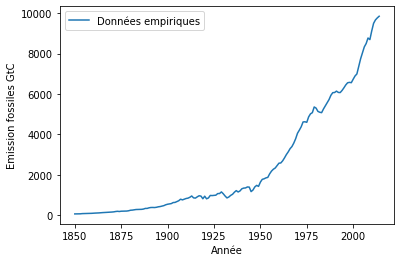

In [3]:
X, Y = loadData('global.1751_2014.csv')
plt.plot(X, Y, label='Données empiriques')
plt.xlabel('Année')
plt.ylabel('Emission fossiles GtC')
plt.legend()

Sur base d'un modèle de croissance exponentiel, trouver la valeur _y_ au bout de
 _n_ années depuis le début des mesures.

Le modèle exponentiel prend un taux de croissance et une valeur initiale.

La valeur au bout de _n_ années se calcul selon la formule générale _y_n = C^n * y_0_

In [4]:
def modeleExponentiel(croissance, y0, n):
    """
    croissance: taux de croissance exprimé en %
    y0: valeur initiale
    n: itération à laquelle prévoir la valeur
    """
    C = 1.0 + croissance / 100.0
    return (C ** n) * y0

## Quelle est le taux de croissance annuel?
Estimation du taux de croissance en utilisant un ajustement de courbe sur base
d'un modèle exponentiel

In [5]:
def ajustement(X, Y):
    """
    X: _x_ connus
    Y: _y_ connus
    """
    x0 = X[0]
    xn = X[len(X) - 1]
    delta = xn - x0
    return (Y[len(Y) - 1]  / Y[0])**(1.0/delta) - 1.0

In [6]:
croissance = ajustement (X, Y) * 100
u0 = Y[0]
Y_ = []
Y_ = [modeleExponentiel(croissance = croissance, y0=u0, n=i) for i in range(len(X))]

Text(0, 0.5, 'Emission fossiles GtC')

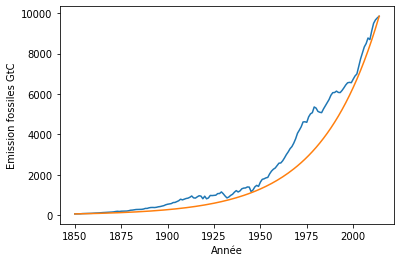

In [7]:
plt.plot(X, Y, label='Données empiriques')
plt.plot(X, Y_, label='Modèle exponentiel')
plt.xlabel('Année')
plt.ylabel('Emission fossiles GtC')

Quel est le temps de doublement?

Astuce:
* Produit: log(M * N) = log(M) + log(N)
* Quotient: log (M/N) = log(M) - log (N)
* Puissance: log(M^p) = p * log(M)
pour M > 0 et N > 0

In [8]:

log(2)/log(1.0+(croissance/100.0))

21.832454762438015